##  Moseli Motsoehli

### Seq to Seq model for comparing text similarity.

__I use the quora question pairs dataset as a test for this although the model is eventually used for text transcribed from recorded speech as a way to evaluate  public speaking__

Siamese lstm to classify similar senrences

In [1]:
#### Libraries
import scipy as sc
from scipy.spatial.distance import cosine
import pandas as pd
import math
import logging
from collections import Counter
from  tqdm import tqdm
from tabulate import tabulate
from Generator import *

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelBinarizer

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import backend as k
from keras import initializers
from keras.optimizers import RMSprop,Adam,Adagrad
from keras.models import Model,Sequential,load_model
from keras.layers import Dense,LSTM,Input,Activation,Flatten,subtract,merge,concatenate,Reshape,Embedding,Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler,EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moselim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
/home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a

## Constants

In [2]:
STRING_SIZE=16
BATCH_SIZE=64
NUM_EPOCHS = 40

## Load Dataset

In [48]:
datafile = "train.csv"

data =  pd.read_csv(datafile,sep=",")[:][:-1]
print("Number of examples: %s"%len(data))
data=data.dropna(subset=['question1','question2', 'is_duplicate'])
data=data.reset_index(drop=True)
print("Number of examples after removing NA: %s"%len(data))
print("\n")
print(data.head(2))
print("\n")
print(data.tail(2))
print("\n")
print("propotion of positives: %s"%np.mean(data["is_duplicate"]))

Number of examples: 404289
Number of examples after removing NA: 404286


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  


            id    qid1    qid2  \
404284  404287  537928  537929   
404285  404288  537930  537931   

                                                question1  \
404284                                  What is one coin?   
404285  What is the approx annual cost of living while...   

                                                question2  is_duplicate  
404284                                  What's this coin?             0  
404285  I am having little hairfall problem but I want...        

### Preprocessing addopted from my Topic Model in ICS661 AKA Thematron

In [3]:
def remove_special(text):
    special_chars = "[~#$%^@&*&()+-_\",?!.:[]\\;><`|{}=\\'=»¿シし]"
    for k in special_chars:
            if type(text) == str:
                if k=="-" or k=="_":
                    text=text.replace(k, "")
                else:
                    text=text.replace(k, " ")       
    return text

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent):
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    #textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

########################################################
########create corpus and create word vectors and training data###########
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p))
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m])
    
    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

def wordvecmatrix(model1,data):
    IO_data={"question1":[],"question2":[],"label":[]}
    pbar = tqdm(range(len(data["question1"])))
    for k in range(len(data["question1"])):
        q1=[]
        q2=[]
        label=[]
        for word in data["question1"][k]:
            try:
                q1.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        for word in data["question2"][k]:
            try:
                q2.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        IO_data["label"].append(data["is_duplicate"][k])
        IO_data["question1"].append(q1) 
        IO_data["question2"].append(q2)
        pbar.update(1)
    print('\007')
    pbar.close()
    return IO_data

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',value="PAD")
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

### Corpus and Wordvectors

In [5]:
sentences1 = list(map(wordTok,data["question1"]))
sentences2 = list(map(wordTok,data["question2"]))

####Truncade and Pad to N words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

data["question1"] = sentences1
data["question2"] = sentences2
dataAll = [data["question1"],data["question2"]] 
dataAll = pd.concat(dataAll)

In [6]:
model1 = Word2Vec(size = 256,sg=1,compute_loss=False,window=4,
                 min_count=1,workers=8)
model1.build_vocab(dataAll)  # prepare the model vocabulary
model1.train(dataAll, total_examples=model1.corpus_count,queue_factor=6, epochs=40)
model1.save("word2vec_256.model")
final_data = wordvecmatrix(model1,data)
print(sentences1[2])
print(len(final_data["question1"][2]))
print(sentences2[2])
print(len(final_data["question2"][2]))
del dataAll

100%|██████████| 404286/404286 [00:29<00:00, 13560.54it/s]


['How', 'can', 'I', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'VPN', '?', 'PAD']
16
['How', 'can', 'Internet', 'speed', 'be', 'increased', 'by', 'hacking', 'through', 'DNS', '?', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
16


In [15]:
print(pd.DataFrame(final_data).head(5))
cosine(model1.wv.word_vec("pad"),model1.wv.word_vec("money"))

                                           question1  \
0  [[-0.047141794, -0.3430948, 0.033490896, -0.03...   
1  [[-0.047141794, -0.3430948, 0.033490896, -0.03...   
2  [[-0.036111936, -0.11472451, -0.19041245, -0.1...   
3  [[-0.3146305, -0.16412322, 0.12478607, -0.1693...   
4  [[0.1407505, -0.58020824, 0.13030632, 0.365536...   

                                           question2  label  
0  [[-0.047141794, -0.3430948, 0.033490896, -0.03...      0  
1  [[-0.047141794, -0.3430948, 0.033490896, -0.03...      0  
2  [[-0.036111936, -0.11472451, -0.19041245, -0.1...      0  
3  [[0.26904523, 0.047650877, -0.62017524, 0.5677...      0  
4  [[0.1407505, -0.58020824, 0.13030632, 0.365536...      0  


AttributeError: 'Model' object has no attribute 'wv'

In [113]:
#split=int(0.8*len(final_data["label"]))
y=final_data["label"]
x1_train,x1_val,x2_train,x2_val,y_train,y_val = tts(final_data["question1"],
                                                    final_data["question2"],
                                                    y,test_size=0.2)

x1_train = np.array(x1_train,dtype='float32')
x1_val = np.array(x1_val,dtype='float32')
x2_train = np.array(x2_train,dtype='float32')
x2_val = np.array(x2_val,dtype='float32')
y_train = np.array(y_train,dtype='float32')
y_val = np.array(y_val,dtype='float32')


#x1_train = np.asarray(final_data["question1"][:split],dtype='float32')
#x1_val = np.asarray(final_data["question1"][split:],dtype='float32')
#x2_train = np.asarray(final_data["question2"][:split],dtype='float32')
#x2_val = np.asarray(final_data["question2"][split:],dtype='float32')
#y_train = np.asarray(y[:split],dtype='float32')
#y_val = np.asarray(y[split:],dtype='float32')

TRAIN_SIZE = len(x1_train)
VAL_SIZE = len(x1_val)
gentrain = get_samples_2_inputs(x1_train,x2_train,y_train,batch_size=BATCH_SIZE)
gentest = get_samples_2_inputs(x1_val,x2_val,y_val,BATCH_SIZE)

In [114]:
print(x1_train.shape)
print(x2_train.shape)
print(x1_val.shape)
print(x2_val.shape)
print(y_train.shape)
print(y_val.shape)

(323428, 16, 256)
(323428, 16, 256)
(80858, 16, 256)
(80858, 16, 256)
(323428,)
(80858,)


Results of the embedding are returned as a list of sentences and their token embeddings, so each sentence is of the form<br>
__(sentence,embeddings for each word)__

### Now Build an LSTM model with 2 inputs and one output

In [115]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [116]:
model1_input = Input(shape=(x1_train.shape[1],x1_train.shape[2]),name="input1")
model1_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM1")(model1_input)
model1 = Model(model1_input,model1_LSTM)

model2_input = Input(shape=(x2_train.shape[1],x2_train.shape[2]),name='input2')
model2_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM2")(model2_input)
model2 = Model(model2_input,model2_LSTM)

merged = subtract([model1_LSTM,model2_LSTM],name="merge")
#model_merged_LSTM = LSTM(64,return_sequences=False,activation='relu',dropout=0.4,recurrent_dropout=0.1,name="LSTM_merge")(merged)
Dense_merged1 = Dense(64,activation="relu",name="dense1")(merged)
model_merged_out = Dense(1,activation="sigmoid",name="output")(Dense_merged1)
model=Model([model1_input,model2_input],model_merged_out)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.998)
model.compile(adam, loss ='binary_crossentropy', metrics=['accuracy'])

lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
callbacks_list = [lrate,earlystopper]
model.fit([x1_train[:400],x2_train[:400]], y_train[:400],
          epochs=1,
          verbose=1,
          batch_size=32,
          validation_split=0.15,
          callbacks=callbacks_list)
model.summary()

Train on 340 samples, validate on 60 samples
Epoch 1/1
340/340 [==============================] - 4s 11ms/step - loss: 0.6443 - acc: 0.6324 - val_loss: 0.6846 - val_acc: 0.6167
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 16, 256)      0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 16, 256)      0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 128)          197120      input1[0][0]                     
__________________________________________________________________________________________________
LSTM2 (LSTM) 

In [117]:
model.fit_generator(gentrain, 
                     steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                     verbose=1,
                     validation_data=gentest,
                     validation_steps=VAL_SIZE//BATCH_SIZE,
                     epochs=NUM_EPOCHS,
                     workers=8,
                     use_multiprocessing=False,
                     callbacks=callbacks_list)
model.save('my_model_siamese_Lstm_final.h5')

Epoch 1/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.5331 - acc: 0.7308 - val_loss: 0.4909 - val_acc: 0.7592
Epoch 2/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4868 - acc: 0.7600 - val_loss: 0.4681 - val_acc: 0.7690
Epoch 3/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4575 - acc: 0.7765 - val_loss: 0.4545 - val_acc: 0.7788
Epoch 4/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4445 - acc: 0.7839 - val_loss: 0.4454 - val_acc: 0.7833
Epoch 5/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4349 - acc: 0.7892 - val_loss: 0.4368 - val_acc: 0.7889
Epoch 6/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4231 - acc: 0.7962 - val_loss: 0.4307 - val_acc: 0.7928
Epoch 7/40
5053/5053 [==============================] - 226s 45ms/step - loss: 0.4146 - acc: 0.8014 - val_loss: 0.4316 - val_acc: 0.7929
Epoch 8/40
5053/5053 [===================

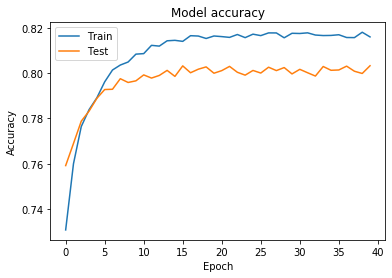

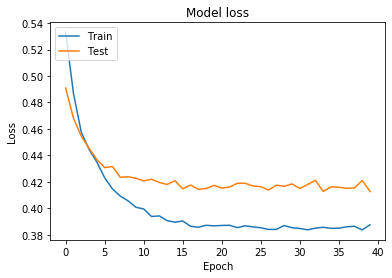

In [118]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [119]:
#model = load_model('my_model_lstm256_word2vec.h5')
model.evaluate([x1_val,x2_val],y=y_val,
              batch_size=BATCH_SIZE)

80858/80858 [==============================] - 21s 262us/step


[0.4162074076711841, 0.8015409730668384]

In [4]:
def inference(x1,x2):
    #tokenize and pad
    x1=wt(x1.lower().strip())
    x2=wt(x2.lower().strip())
    
    if len(x1)>=16:
        x1=x1[:16]
    else:
        while(len(x1)<16):
            x1.append("pad")
            
    if len(x2)>=16:
        x2=x2[:16]
    else:
        while(len(x2)<16):
            x2.append("pad")
    
    print("--------words----------")
    print(x1)
    print(x2)
    
    model1 = Word2Vec.load("word2vec_256.model")
    siamese_model = load_model('my_model_siamese_Lstm_final.h5')
    q1=[]
    q2=[]
    label=[]
    for word in x1:
        try:
            q1.append(model1.wv.word_vec(word))
        except Exception as e:
            q1.append(model1.wv.word_vec("pad"))
            continue
    for word2 in x2:
        try:
            q2.append(model1.wv.word_vec(word2))
        except Exception as e2:
            q2.append(model1.wv.word_vec("pad"))
            continue
    
    x1 = np.asarray(q1,dtype='float32').reshape((1,16,256))
    x2 = np.asarray(q2,dtype='float32').reshape((1,16,256))
    sim_prob = siamese_model.predict([x1,x2])
    return sim_prob
    

In [9]:
string1 = "How is equity described in a formal offer letter ?"
string2 = "Predicted positive probability offer letter ?"

In [10]:
prob=inference(string1,string2)[0][0]
print("Predicted positive probability: %s"%prob)
print("true label: %s"%0)

--------words----------
['how', 'is', 'equity', 'described', 'in', 'a', 'formal', 'offer', 'letter', '?', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
['predicted', 'positive', 'probability', 'offer', 'letter', '?', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
Predicted positive probability: 0.31058604
true label: 0
